Transfer Learning for Computer Vision Tutorial
==============================================


In this tutorial, you will learn how to use Deep CNN models as fixed feature extractors which can be considered a one scenario of transfer learning. We will freeze the weights for all of the network except that of the final fully
connected layer. This last fully connected layer will be replaced by a classification algorithm from scikit-learn such as Support Vector Machines, Naive Bayes and Decision Tree.
    
More information about CNN as feature extractors can be found in: https://cs231n.github.io/transfer-learning/ and in the Andrej Karpathy recipe for training and using Neural Networks: http://karpathy.github.io/2019/04/25/recipe/


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. This is a very small dataset to build a full CNN model from scratch. However, as we are using a pre-trained model just to compute features, we should be able to generalize reasonably well training only the classifier on top of those.

In [2]:
# Data augmentation and normalization and resizing to the right network parameters.
#Transformations suggested by the PyTorch transferlearning tutorial.
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


data_dir = 'data'
image_dataset = datasets.ImageFolder(os.path.join(data_dir), data_transforms)

dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)

dataset_sizes = len(image_dataset) 

class_names = image_dataset.classes

# If GPU is available, we can send our data and model to run on it.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


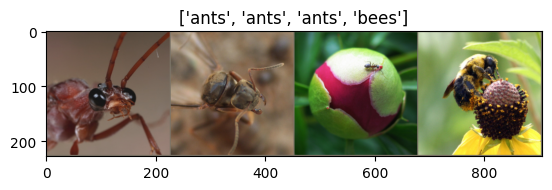

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data to visualize
inputs, classes = next(iter(dataloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
#checking the classes in the mini-batch
classes

tensor([0, 0, 0, 1])

ConvNet as fixed feature extractor
==================================

Here we are initializing our feature extractor as a ResNet18 architecture pre-trained on ImageNet1K. You can find more pre-trained models on the PyTorch Model Zoo: https://pytorch.org/serve/model_zoo.html Any other model could be used in this step.

Setting `requires_grad = False` freezes the network so that PyTorch won't be computing gradients to update it.
when calling the `backward()` function.


In [5]:
from torchview import draw_graph
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Vizualizing the Network Computation Graph

To vizualize the computational graph (all operations conducted and layers) we can use the Torchview library: https://github.com/mert-kurttutan/torchview

for that you will need to install graphview and torchview. For graphview to work you need to install first dot_view according to the OS you're using:

**Linux: (Debian Based)**
apt-get install graphviz

**Windows:**
choco install graphviz

**MacOS:**
brew install graphviz


# Torch FX for feature extraction

PyTorch now offers a functionality (Torch FX) to easily extract the information from any of the computing layers of a network. Here we all the operations it contains. 

In [6]:
from torchvision.models.feature_extraction import get_graph_node_names
nodes, _ = get_graph_node_names(model_conv)
print(nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

## Choosing from where to compute features

Torch now offers a feature extraction module to assist on the task of collecting the information on any step in the network. For this example we will get the features (representation) at the last layer of the network (`flatten`) before the classification one.

In [7]:
from torchvision.models.feature_extraction import create_feature_extractor

feature_extractor = create_feature_extractor(model_conv, return_nodes=['flatten'])

# here we can test just passing a vectors of zeros, what is the output of the network.
out = feature_extractor(torch.zeros(1, 3, 224, 224))
out['flatten'].shape

torch.Size([1, 512])

In [8]:
def extract_features():
    X = np.empty(shape=(0, 512))
    y = np.empty(shape=0)
    iterator = iter(dataloaders)
    for img, labels in iterator:
        features = feature_extractor(img)['flatten']
        # Convert to numpy and add to the list. The detach() function is important before
        # Converting the torch tensor to numpy in order to detach the gradients associated with it.
        X = np.vstack((X, features.detach().numpy()))
        y = np.hstack((y, labels))
    return X, y

features, labels = extract_features()

In [9]:
print(features.shape)
print(labels.shape)

(397, 512)
(397,)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25,
                                                    stratify=labels, 
                                                    random_state=42)

# Scaling the dataset prior to feeding it too the model
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

dt = DecisionTreeClassifier().fit(X_train, y_train)
svm_classifier = SVC().fit(X_train, y_train)
logistic = LogisticRegression().fit(X_train, y_train)
nb = GaussianNB().fit(X_train, y_train)


print("Decision Tree (LOG635) Score: " + str(dt.score(X_test, y_test)))
print("Support Vector Machine (Cours 10) Score: " + str(svm_classifier.score(X_test, y_test)))
print("Logist Regression (LOG635 et Cours 6) Score  : " + str(logistic.score(X_test, y_test)))
print("Gaussian Naive Bayes (LOG635* Cours 4 et 5) Score: " + str(nb.score(X_test, y_test)))

Decision Tree (LOG635) Score: 0.928
Support Vector Machine (Cours 10) Score: 0.916
Logist Regression (LOG635 et Cours 6) Score  : 0.912
Gaussian Naive Bayes (LOG635* Cours 4 et 5) Score: 0.896


Vizualizing the feature vector
==========================

A good way to vizualize the quality of your feature extraction model is to apply a dimensionality reduction method to transform your data from a $d$ to 2 dimensions and plot the different classes. This step, of course, can be made with any dimensionality reduction technique (Such as PCA for instance). However, for the means of vizualization of our feature vectors (also called Embeddings in the literature), there exists better techniques for this task such as T-distributed stochastic neighbor embedding (TSNE) or Unified Manifold Approximation (UMAP).

T-SNE can be found on scikit-learn as part of the manifold package: https://scikit-learn.org/0.16/modules/generated/sklearn.manifold.TSNE.html

UMAP is not on scikit-learn(yet) however there is a library following scikit-learn API to use it: https://umap-learn.readthedocs.io/en/latest/


/Users/rafaelmenelauoliveiraecruz/opt/anaconda3/envs/gti771/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


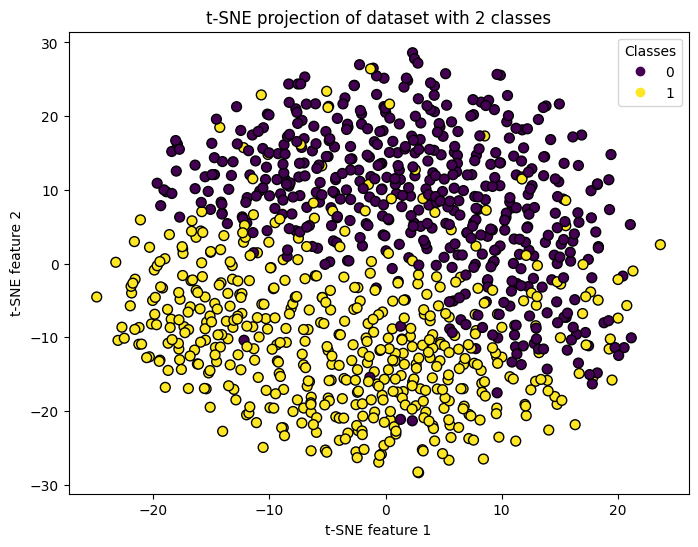

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification


features, labels = make_classification(n_samples=1000, n_features=30)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features)

# Step 3: Plot the t-SNE projection
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)

# Adding legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE projection of dataset with 2 classes')
plt.show()

# Plotting with UMAP

The main difference and benefit of UMAP compared to t-SNE and PCA is that UMAP preserves both local and global data structure better, making it more effective for visualizing complex, high-dimensional data while being faster and scalable to larger datasets.

In order to install UMAP you must use the commant : pip install umap-learn

More information about this type of dimensionality reduction can be found in its documentation : https://umap-learn.readthedocs.io/en/latest/

/Users/rafaelmenelauoliveiraecruz/opt/anaconda3/envs/gti771/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-04 13:01:19.240355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/rafaelmenelauoliveiraecruz/opt/anaconda3/envs/gti771/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_ac

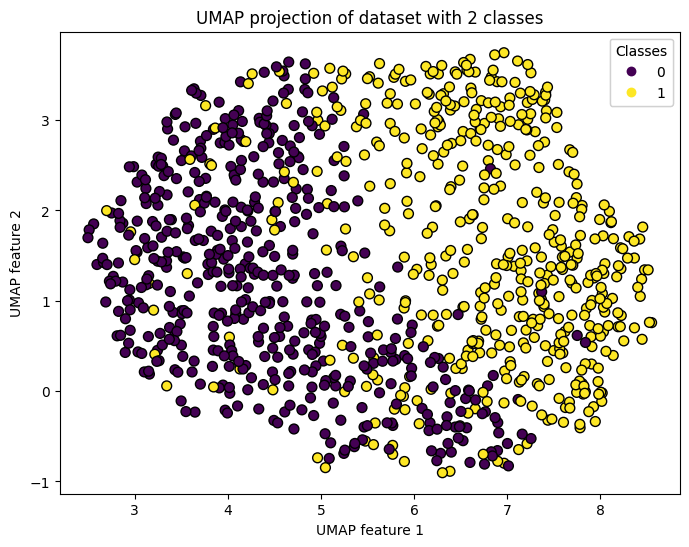

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import umap


umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)

legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.title('UMAP projection of dataset with 2 classes')
plt.show()
